# EbayesThresh Python화 시도

SEOYEON CHOI  
2024-06-01

https://cran.r-project.org/web/packages/EbayesThresh/EbayesThresh.pdf

-   R코드 Python화
    -   R코드 결과와 비교하면서

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import EbayesThresh

`beta.cauchy`

> Given a value or vector x of values, find the value(s) of the function
> $\beta(x) = g(x)/\phi(x) − 1$, where $g$ is the convolution of the
> quasi-Cauchy with the normal density $\phi(x)$.

*x가 입력되면 코시 분포와 정규 분포를 혼합해서 함수 베타 구하기*

In [2]:
EbayesThresh.beta_cauchy(np.array([-2,1,0,-4,8,50]))

/home/csy/Dropbox/sy_hub/posts/1_Note/EbayesThresh/utils.py:25: RuntimeWarning: divide by zero encountered in divide
  beta[j] = (norm.pdf(0) / phix[j] - 1) / (x[j] ** 2) - 1

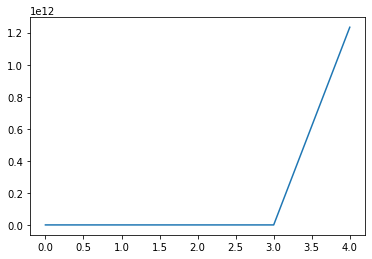

In [3]:
plt.plot(EbayesThresh.beta_cauchy(np.array([-2,1,0,-4,8,50])))

`beta.laplace`

> Given a single value or a vector of $x$ and $s$, find the value(s) of
> the function $\beta(x; s, a) = \frac{g(x; s, a)}{f_n(x; 0, s)}−1$,
> where $f_n(x; 0, s)$ is the normal density with mean $0$ and standard
> deviation $s$, and $g$ is the convolution of the Laplace density with
> scale parameter a, $γa(\mu)$, with the normal density $f_n(x; µ, s)$
> with mean mu and standard deviation $s$.

*평균이 $\mu$이며, 스케일 파라메터 a를 가진 라플라스와 정규분포의
합성함수 $g$와 평균이 0이고 표준편차가s인 f로 계산되는 함수 베타*

In [4]:
EbayesThresh.beta_laplace(np.array([-2,1,0,-4,8,50]),s=1)

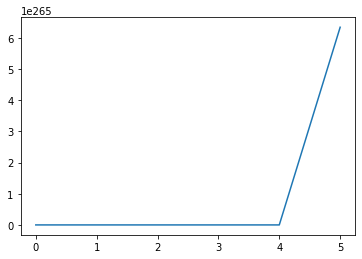

In [5]:
plt.plot(EbayesThresh.beta_laplace(np.array([-2,1,0,-4,8,50]),s=1))

In [6]:
for i in range(1,7):
    print(EbayesThresh.beta_laplace(np.array([-2,1,0,-4,8,50]),s=i,a=1))

[ 8.90821055e-001 -1.62658317e-001 -3.44320458e-001  1.11763852e+002
  5.47362128e+010  1.26890791e+266]
[-3.97301589e-002 -1.29919250e-001 -1.57261541e-001  4.89966520e-001
  1.72626254e+001  1.86200309e+115]
[-5.47817038e-02 -7.85266727e-02 -8.62291039e-02  5.07055851e-02
  7.25566365e-01  1.35975389e+41]
[-4.17233012e-02 -5.04965878e-02 -5.33904683e-02 -5.20319315e-03
  1.67493780e-01  2.44910886e+16]
[-3.07299814e-02 -3.46568340e-02 -3.59594764e-02 -1.47336507e-02
  5.42137177e-02  1.68155326e+06]
[-2.30695463e-02 -2.50691640e-02 -2.57340346e-02 -1.49952854e-02
  1.85602410e-02  1.12493577e+02]

/home/csy/Dropbox/sy_hub/posts/1_Note/EbayesThresh/utils.py:46: RuntimeWarning: divide by zero encountered in divide
  rat2 = 1/np.abs(xma)

`-` R 결과 비교

``` r
[1]   0.890821055  -0.129919250  -0.086229104  -0.005203193   0.054213718 112.493576777
```

`Mad(Median Absolute Deviation)`

> 중앙값 절대 편차, 분산이나 퍼진 정도 확인 가능

In [7]:
EbayesThresh.mad(np.array([1, 2, 3, 3, 4, 4, 4, 5, 5.5, 6, 6, 6.5, 7, 7, 7.5, 8, 9, 12, 52, 90]))

`wfromt`

> Given a value or vector of thresholds and sampling standard deviations
> (sd equals 1 for Cauchy prior), find the mixing weight for which this
> is(these are) the threshold(s) of the posterior median estimator. If a
> vector of threshold values is provided, the vector of corresponding
> weights is returned.

*주어진 임계값과 표준편차에 대해, posterior median estimator에서 이
임계값이 나오도록 하는 혼합 가중치를 계산하는 함수가 제공된다.*

In [8]:
EbayesThresh.wfromt(np.array([2,3,5]),prior='cachy')

`wfromx`

> Suppose the vector $(x_1, \cdots, x_n)$ is such that $x_i$ is drawn
> independently from a normal distribution with mean $\theta_i$ and
> standard deviation $s_i$ ($s_i$ equals $1$ for Cauchy prior). The
> prior distribution of the $\theta_i$ is a mixture with probability
> $1 − w$ of zero and probability $w$ of a given symmetric heavy-tailed
> distribution. This routine finds the marginal maximum likelihood
> estimate of the parameter $w$.

*주어진 정규 분포 데이터에 대해 $\theta_𝑖$의 사전 분포가 주어진
상황에서, 모수 $w$의 최대우도 추정치를 계산하는 방법을 제공한다*

In [20]:
s = np.array([0] * 90 + [5] * 10)
x = np.random.normal(0, s, size=100)

In [21]:
EbayesThresh.wfromx(x, prior = "cauchy")

`isotone`

> Isotonic Regression은 입력 변수에 따른 출력 변수의 단조 증가(monotonic
> increasing) 또는 감소(monotonic decreasing) 패턴을 찾는 방법

In [9]:
beta = EbayesThresh.beta_cauchy(np.array([-2,1,0,-4]))
w = np.ones(len(beta))
aa = w + 1/beta
ps = w + aa
ww = 1/aa**2
wnew = EbayesThresh.isotone(ps, ww, increasing = False)
wnew

`wmonfromx`

> Given a vector of data, find the marginal maximum likelihood choice of
> weight sequence subject to the constraints that the weights are
> monotone decreasing

*데이터에 대해 가중치 시퀀스를 선택하는 과정에서 조건이 주어지는데, 이
가중치 시퀀스는 각각의 가중치 값이 단조 감소해야 하며, 주어진 데이터에
대한 최대 우도를 갖도록 선택되어야 함.*

In [8]:
s = np.array([0] * 30 + [5] * 10)
x = np.random.normal(0, s, size=40)

In [9]:
EbayesThresh.wmonfromx(x, prior = "cauchy")

`thresh`

> 임계값 t를 이용해서 데이터 조정

In [6]:
EbayesThresh.threshold(np.array(range(-5,5)), t=1.4, hard=False)

`negloglik.laplace`

> Marginal negative log likelihood function for laplace prior.

-   라플라스 프라이어에 대한 한계음의로그우도함수 계산

In [ ]:
a <- xpar[2]
        
        # Calculate the range of w given a, using negative monotonicity
        # between w and t
    wlo <- wfromt(thi, ss, a = a)
    whi <- wfromt(tlo, ss, a = a)
    wlo <- max(wlo)
    whi <- min(whi)
    loglik <- sum(log(1 + (xpar[1] * (whi - wlo) + wlo) *
                          beta.laplace(xx, ss, a)))

In [2]:
EbayesThresh.negloglik_laplace(np.array([0.5,0.5,0.3]),np.array([1,2,3,4,5]),1,np.sqrt(2 * np.log(len(np.array([1,2,3,4,5])))) * 1,np.array([0,0,0]))

In [6]:
len(np.array([np.array([3,4,5])]))

\`wanda

> Given a vector of data and a single value or vector of sampling
> standard deviations, find the marginal maximum likelihood choice of
> both weight and scale factor under the Laplace prior